In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from esmpy.estimators import SmoothNMF
from esmpy.measures import find_min_angle, find_min_MSE, ordered_mse


In [3]:
C = 15
L = 200
P = 100**2
seed = 0
n_poisson = 50


In [44]:
def syntheticG(L=200, C=15, seed=None):

    np.random.seed(seed=seed)
    n_el = 118
    n_gauss = np.random.randint(2, 7,[C])
    l = np.arange(0, 1, 1/L)
    mu_gauss = np.random.rand(n_el)
    sigma_gauss = 1/n_el + np.abs(np.random.randn(n_el))/n_el*3

    G = np.zeros([L,C])

    def gauss(x, mu, sigma):
        # return np.exp(-(x-mu)**2/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
        return np.exp(-(x-mu)**2/(2*sigma**2))

    for i, c in enumerate(n_gauss):
        inds = np.random.choice(n_el, size=[c] , replace=False)
        for ind in inds:
            w = 0.3+0.7*np.random.rand()
            G[:,i] += w * gauss(l, mu_gauss[ind], sigma_gauss[ind])
    return G

def load_toy_images(downsampling_factor):
    im1 = plt.imread("../esmpy/datasets/toy-problem/layer1.png")

    im1 = (1-np.mean(im1, axis=2)) *0.5

    im2 = plt.imread("../esmpy/datasets/toy-problem/layer2.png")
    im2 = (1-np.mean(im2, axis=2)) *0.5

    im3 = plt.imread("../esmpy/datasets/toy-problem/layer3.png")
    im3 = (1-np.mean(im3, axis=2)) *0.5

    im0 = 1 - im1 - im2 - im3

    Hdot = np.array([im0, im1, im2, im3])
    n = downsampling_factor
    b = Hdot.shape[2]//n

    Hdot = Hdot.reshape(4, -1, n, b, n).sum((-1, -3)) /(n*n)

    return Hdot


def create_toy_problem(L, C, n_poisson, downsampling_factor, seed=None):
    np.random.seed(seed=seed)
    G = syntheticG(L,C, seed=seed)
    Hdot = load_toy_images(downsampling_factor)
    K = len(Hdot) 
    Hdotflat = Hdot.reshape(K, -1)
    Wdot = np.abs(np.random.laplace(size=[C, K]))
    Ddot = G @ Wdot
    Ydot = Ddot @ Hdotflat
    Y = 1/n_poisson * np.random.poisson(n_poisson * Ydot)
    shape_2d = Hdot.shape[1:]
    return G, Wdot, Ddot, Hdot, Hdotflat, Ydot, Y, shape_2d, K

def plot_results(Ddot, D, Hdotflat, Hflat):
    fontsize = 30
    scale = 15
    aspect_ratio = 1.4
    marker_list = ["-o","-s","->","-<","-^","-v","-d"]
    mark_space = 20
    # cmap = plt.cm.hot_r    
    cmap = plt.cm.gray_r
    vmax = 1
    vmin = 0
    K = len(H)
    L = len(D)
    
    angles, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
    mse = ordered_mse(Hdotflat, Hflat, true_inds)


    fig, axes = plt.subplots(3,K,figsize = (scale/K * 3 * aspect_ratio,scale))
    x = np.linspace(0,1, num = L)
    for i in range(K): 
        print(Ddot.shape)
        axes[2,i].plot(x,Ddot.T[i,:],'bo',label='truth',linewidth=4)
        axes[2,i].plot(x,D[:,true_inds[i]],'r-',label='reconstructed',markersize=3.5)
        axes[2,i].set_title("{:.2f} deg".format(angles[i]),fontsize = fontsize-2)
        axes[2,i].set_xlim(0,1)

        axes[1,i].imshow((Hflat[true_inds[i],:]).reshape(shape_2d),vmin = vmin, vmax = vmax , cmap=cmap)
        axes[1,i].set_title("{:.2f} MSE".format(mse[true_inds[i]]),fontsize = fontsize-2)
        # axes[i,1].set_ylim(0.0,1.0)
        axes[1,i].tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)

        im = axes[0,i].imshow(Hdotflat[i].reshape(shape_2d),vmin = vmin, vmax = vmax, cmap=cmap)
        axes[0,i].set_title("Phase {}".format(i),fontsize = fontsize)
        axes[0,i].tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)
        axes[2,0].legend()

    rows = ["True maps","Reconstructed maps","Spectra"]

    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=90, fontsize=fontsize)


    fig.subplots_adjust(right=0.84)
    # put colorbar at desire position
    cbar_ax = fig.add_axes([0.85, 0.5, 0.01, 0.3])
    fig.colorbar(im,cax=cbar_ax)

    # fig.tight_layout()

    plt.show()
    
        

SyntaxError: non-default argument follows default argument (151509487.py, line 45)

# Create a synthetic problem

Text(0.5, 1.0, 'Spectral response of each elements')

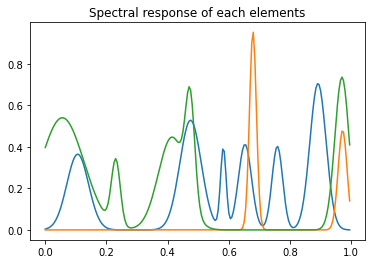

In [5]:
G = syntheticG(L,C, seed)
l = np.arange(0, 1, 1/L)
plt.plot(l, G[:,:3])
plt.title("Spectral response of each elements")


[[0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [2. 2. 2. 3. 3. 3.]
 [2. 2. 2. 3. 3. 3.]
 [2. 2. 2. 3. 3. 3.]]
[[0.  0.5 1. ]
 [1.  1.5 2. ]
 [2.  2.5 3. ]]
(4, 26, 26)
(4, 13, 13)


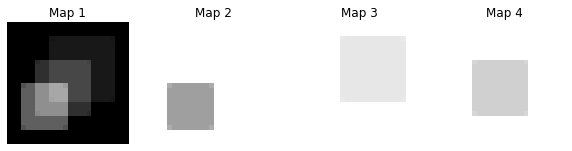

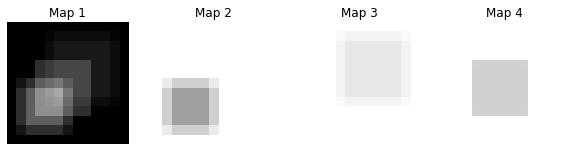

In [40]:

Hdot = load_toy_images()
import numpy as np

a = np.array([[0,1], [2,3]])
a = np.kron(a, np.ones((3,3)))
n = 2
b = 26//n
print(a)
# a_downsampled = a.reshape(-1, n, b, n).sum((-1, -3)) /(n*n)

print(a_downsampled)
Hdotsmall = load_toy_images()
print(Hdotsmall.shape)
Hdotsmall = Hdotsmall.reshape(4, -1, n, b, n).sum((-1, -3)) /(n*n)
print(Hdotsmall.shape)

vmin, vmax = 0,1
cmap = plt.cm.gray_r
plt.figure(figsize=(10, 4))
for i, hdot in enumerate(Hdot):
    plt.subplot(1,4,i+1)
    plt.imshow(hdot, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.title(f"Map {i+1}")
vmin, vmax = 0,1
cmap = plt.cm.gray_r
plt.figure(figsize=(10, 4))
for i, hdot in enumerate(Hdotsmall):
    plt.subplot(1,4,i+1)
    plt.imshow(hdot, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.title(f"Map {i+1}")


In [7]:
G, Wdot, Ddot, Hdot, Hdotflat, Ydot, Y, shape_2d, K = create_toy_problem(L, C, n_poisson)

# Solve the problem

In [41]:

mu = 0
lambda_L = 1


params = {}
params["tol"]=1e-6
params["max_iter"] = 50
params["hspy_comp"] = False
params["verbose"] = 1
params["epsilon_reg"] = 1
params["linesearch"] = False
params["shape_2d"] = shape_2d
params["n_components"] = K

estimator = SmoothNMF(mu=mu, lambda_L=lambda_L, G = None, **params)
D = estimator.fit_transform(Y)
Hflat = estimator.H_
H = Hflat.reshape([Hflat.shape[0], *shape_2d])
W = estimator.W_
print(D.shape)

4


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 50: loss 0.010,  76.210 it/s
It 20 / 50: loss 0.010,  80.649 it/s
It 30 / 50: loss 0.010,  82.255 it/s
It 40 / 50: loss 0.010,  82.848 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 minutes and 1.0 seconds.
(200, 4)


In [42]:
        
angles, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
mse = ordered_mse(Hdotflat, Hflat, true_inds)
print("angles : ", angles)
print("mse : ", mse)

angles :  [1.1202295535632616, 9.736507343865846, 21.79352643716015, 15.385938753776832]
mse :  [0.0066290899423405835, 0.0008678253781606648, 0.0040978837518458435, 0.007050641128071456]


(200, 4)
(200, 4)
(200, 4)
(200, 4)


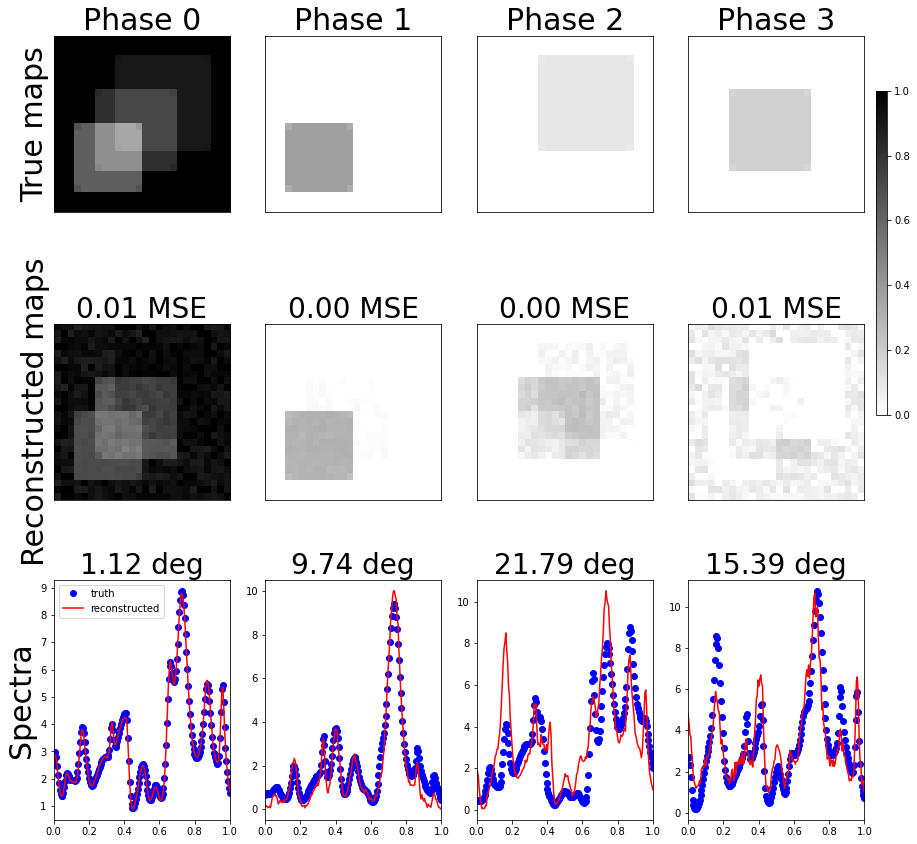

In [43]:
plot_results(Ddot, D, Hdotflat, Hflat)